In [1]:
# Import library yang diperlukan
import zipfile
import os
import matplotlib.pyplot as plt
from keras.preprocessing import image
from tensorflow.keras.utils import image_dataset_from_directory, array_to_img, img_to_array
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras import layers
from tensorflow.data import AUTOTUNE
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

import tensorflow as tf
tf.get_logger().setLevel('ERROR')

## Load Data

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
# Ekstrak dataset
img_zip = 'drive/My Drive/dataset/Prak. ML/Modul 6/rps.zip'

if not os.path.exists(img_zip):
    print(f"File {img_zip} tidak ditemukan.")
else:
    try:
        zip_ref = zipfile.ZipFile(img_zip, 'r')  # Membaca local path
        zip_ref.extractall('/dataset')  # Extract .zip file
        zip_ref.close()
        print("Ekstraksi berhasil.")
    except zipfile.BadZipFile:
        print(f"File {img_zip} bukan file zip yang valid.")

Ekstraksi berhasil.


In [4]:
DATASET_DIR = "/dataset/rps"
IMAGE_SIZE = (150, 150)
BATCH_SIZE = 32

In [5]:
train_ds = image_dataset_from_directory(
  DATASET_DIR,
  validation_split=0.2,
  subset="training",
  label_mode='categorical',
  seed=123,
  image_size=IMAGE_SIZE,
  batch_size=BATCH_SIZE)

val_ds = image_dataset_from_directory(
  DATASET_DIR,
  validation_split=0.2,
  subset="validation",
  label_mode='categorical',
  seed=123,
  image_size=IMAGE_SIZE,
  batch_size=BATCH_SIZE)

Found 2520 files belonging to 3 classes.
Using 2016 files for training.
Found 2520 files belonging to 3 classes.
Using 504 files for validation.


In [6]:
# class_names = train_ds.class_names
# print(class_names)
class_names = {'paper': 0, 'rock': 1, 'scissors': 2}
print(class_names)

{'paper': 0, 'rock': 1, 'scissors': 2}


## EDA

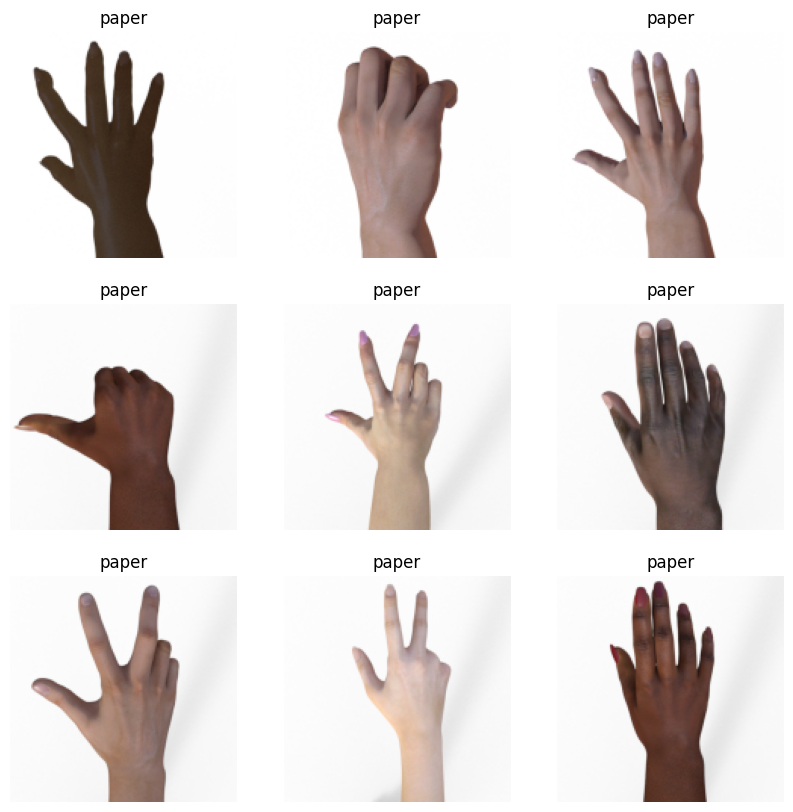

In [7]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds:
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(list(class_names.keys())[np.argmax([i])])
        plt.axis("off")

In [8]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 150, 150, 3)
(32, 3)


## Preprocessing

In [9]:
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Image Augmentation

In [10]:
img_augmentation = Sequential(
    [
        # layers.Rescaling(1./255),
        layers.RandomRotation(factor=0.15),
        layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
        layers.RandomFlip(),
        layers.RandomContrast(factor=0.1),
    ],
    name="img_augmentation",
)

## Build Model

In [11]:
def build_model():
    inputs = layers.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
    x = img_augmentation(inputs)
    model = EfficientNetB3(include_top=False, input_tensor=x, weights="imagenet")

    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)
    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(len(class_names), activation="softmax", name="pred")(x)

    # Compile
    model = Model(inputs, outputs, name="EfficientNet")
    optimizer = Adam(learning_rate=1e-2)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )
    return model

In [12]:
model = build_model()

43941136/43941136 [==============================] - 0s 0us/step


In [13]:
model.summary()

Model: "EfficientNet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 img_augmentation (Sequenti  (None, 150, 150, 3)          0         ['input_1[0][0]']             
 al)                                                                                              
                                                                                                  
 rescaling (Rescaling)       (None, 150, 150, 3)          0         ['img_augmentation[0][0]']    
                                                                                                  
 normalization (Normalizati  (None, 150, 150, 3)          7         ['rescaling[0][0]']

## Train Model

In [14]:
history = model.fit(
    train_ds,
    epochs = 10,
    validation_data=train_ds,
)

Epoch 1/10
63/63 [==============================] - 38s 297ms/step - loss: 0.3955 - accuracy: 0.8953 - val_loss: 0.1444 - val_accuracy: 0.9603
Epoch 2/10
63/63 [==============================] - 9s 143ms/step - loss: 0.3143 - accuracy: 0.9340 - val_loss: 0.0797 - val_accuracy: 0.9702
Epoch 3/10
63/63 [==============================] - 7s 116ms/step - loss: 0.2364 - accuracy: 0.9469 - val_loss: 0.0134 - val_accuracy: 0.9975
Epoch 4/10
63/63 [==============================] - 8s 120ms/step - loss: 0.2092 - accuracy: 0.9588 - val_loss: 0.0055 - val_accuracy: 0.9980
Epoch 5/10
63/63 [==============================] - 9s 145ms/step - loss: 0.2189 - accuracy: 0.9598 - val_loss: 0.0033 - val_accuracy: 1.0000
Epoch 6/10
63/63 [==============================] - 7s 116ms/step - loss: 0.4251 - accuracy: 0.9469 - val_loss: 0.0335 - val_accuracy: 0.9861
Epoch 7/10
63/63 [==============================] - 8s 121ms/step - loss: 0.2294 - accuracy: 0.9653 - val_loss: 0.0157 - val_accuracy: 0.9936
Epoch

In [15]:
import os
if os.path.exists('./model')==False:
    os.mkdir('./model')

In [16]:
model.save("./model/modul6_EfficientNet.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [17]:
model = load_model("./model/modul6_EfficientNet.h5")

## Evaluation

In [18]:
loss, accuracy = model.evaluate(val_ds)
print("Validation: \nAccuracy = %f  \nLoss = %f " % (accuracy, loss))

16/16 [==============================] - 6s 173ms/step - loss: 0.0075 - accuracy: 0.9960
Validation: 
Accuracy = 0.996032  
Loss = 0.007498 


In [19]:
images = []
#predict one batch validation dataset
dt = val_ds.take(1)
preds = model.predict(val_ds)

#get first ten image
i = 0
for data in dt:
    for d in data[0]:
        images.append(array_to_img(d))
        i+=1
        if i == 10:
            break

16/16 [==============================] - 4s 61ms/step


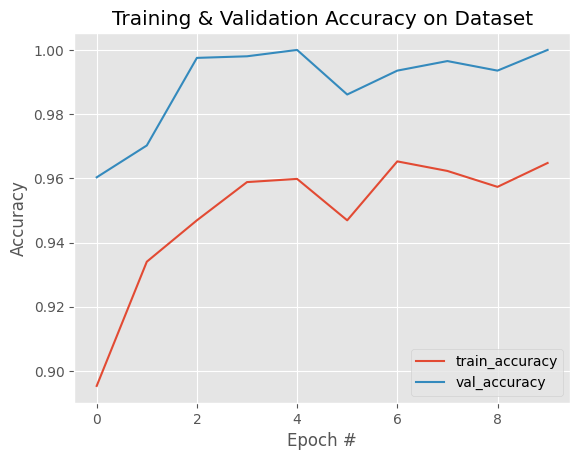

In [20]:
N = np.arange(0, 10)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, history.history["accuracy"], label="train_accuracy")
plt.plot(N, history.history["val_accuracy"], label="val_accuracy")
plt.title("Training & Validation Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="best")

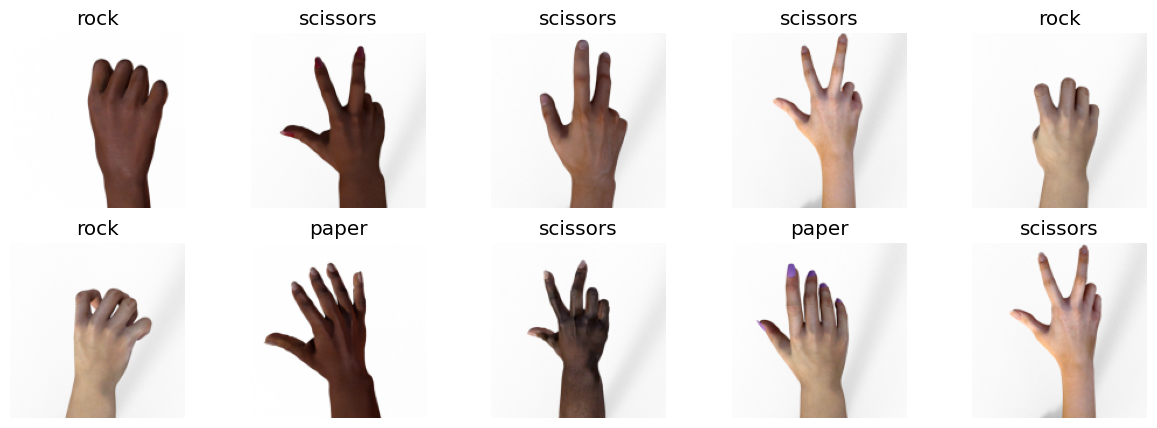

In [21]:
#Predicted result
plt.figure(figsize=(15, 5))
plt.tight_layout()

for i in range(10):
    ax = plt.subplot(2, 5, i + 1)
    plt.imshow(images[i])
    plt.title(list(class_names.keys())[np.argmax(preds[i])])
    plt.axis("off")

In [23]:
y_pred = model.predict(val_ds)
y_preds = np.argmax(y_pred, axis=1)
y_true =  np.array([])
for x, y in val_ds:
  y_true = np.concatenate([y_true, np.argmax(y.numpy(), axis=-1)])
print(classification_report(y_true, y_preds, target_names=list(class_names.keys())))

16/16 [==============================] - 1s 59ms/step
              precision    recall  f1-score   support

       paper       0.99      0.99      0.99       169
        rock       1.00      0.99      1.00       175
    scissors       0.99      1.00      1.00       160

    accuracy                           1.00       504
   macro avg       1.00      1.00      1.00       504
weighted avg       1.00      1.00      1.00       504

